<a href="https://colab.research.google.com/github/nitaymayo/My_Portfolio/blob/main/AI/Tensorflow/Transfer_Learning/Transfer_Learning_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Scailing Up

This notebook is about taking the best models from the last 2 notebooks and making them bigger
(on food101 dataset, 101 categories clasifier)

## Preperation for the models

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-11 19:52:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-11 19:52:12 (99.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves, make_confusion_matrix, unzip_data, walk_through_dir, compare_historys, create_tensorboard_callback

In [ ]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir_10_percent = "101_food_classes_10_percent/train"
test_dir_10_percent = "101_food_classes_10_percent/test"


--2023-01-11 19:52:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  21.8MB/s    in 87s     

2023-01-11 19:53:41 (17.8 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## The big  model:

### create checkpoint callback

In [1]:
checkpoint_path = "101_classes_10_percent_data_checkpoint/model.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weight_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

NameError: ignored

###create augmentation layer:

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

In [ ]:
augmentation_layer = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
# Creating and Compiling the model
from tensorflow.python import training
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,))

x = augmentation_layer(inputs, training=True)

x = base_model(x)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Train the model

In [ ]:
history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[checkpoint_callback,
                                   create_tensorboard_callback(dir_name="scaling_up",
                                                               experiment_name="10_percent_data")])

### Fine tuning 

In [ ]:
# Making the model layers trainable(Unfreezing)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# ReCompiling the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Printing the layers status
for i in model_1.layers:
  print(i.name, i.trainable)

In [ ]:
# Printing the hub-model layers
for i, layer in enumerate(model_1.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
# Training the fine-tuned model
initial_epoch = 5
fine_tune_epoch = initial_epoch + 5

history_1_fine_tune = model_1.fit(train_data_10_percent,
                                  epochs=fine_tune_epoch,
                                  initial_epoch=history_1.epoch[-1],
                                  validation_data=test_data,
                                   validation_steps=int(0.15 * len(test_data)),                                 
                                  callbacks=[create_tensorboard_callback(dir_name="scaling_up",
                                                                          experiment_name="10_percent_data_fine_tune")])

### Tensorboard

In [ ]:
! tensorboard dev upload --logdir /content/scaling_up \
  --name "scaling_up"

### save and load model

In [ ]:
model_1.save("/content/drive/MyDrive/tensorflow course/101_food_calsifier_10_percent_data_model")

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow course/101_food_calsifier_10_percent_data_model")

In [ ]:
loaded_model.evaluate(test_data)

In [ ]:
model_1.evaluate(test_data)

## Model 2: pretrained model

###loading the model

In [ ]:
# Loding Pretrained model
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

model_2 = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

loaded_model_results = model_2.evaluate(test_data)
loaded_model_results

In [ ]:
# Evaluating the model
preds_probs = model_2.predict(test_data, verbose=1)

790/790 [==============================] - 77s 96ms/step


In [ ]:
preds_classes = preds_probs.argmax(axis=1)
preds_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
import sklearn

In [ ]:
sklearn_acc = sklearn.metrics.accuracy_score(y_labels, preds_classes)
sklearn_acc

0.6077623762376237

###confusion matrix

In [ ]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

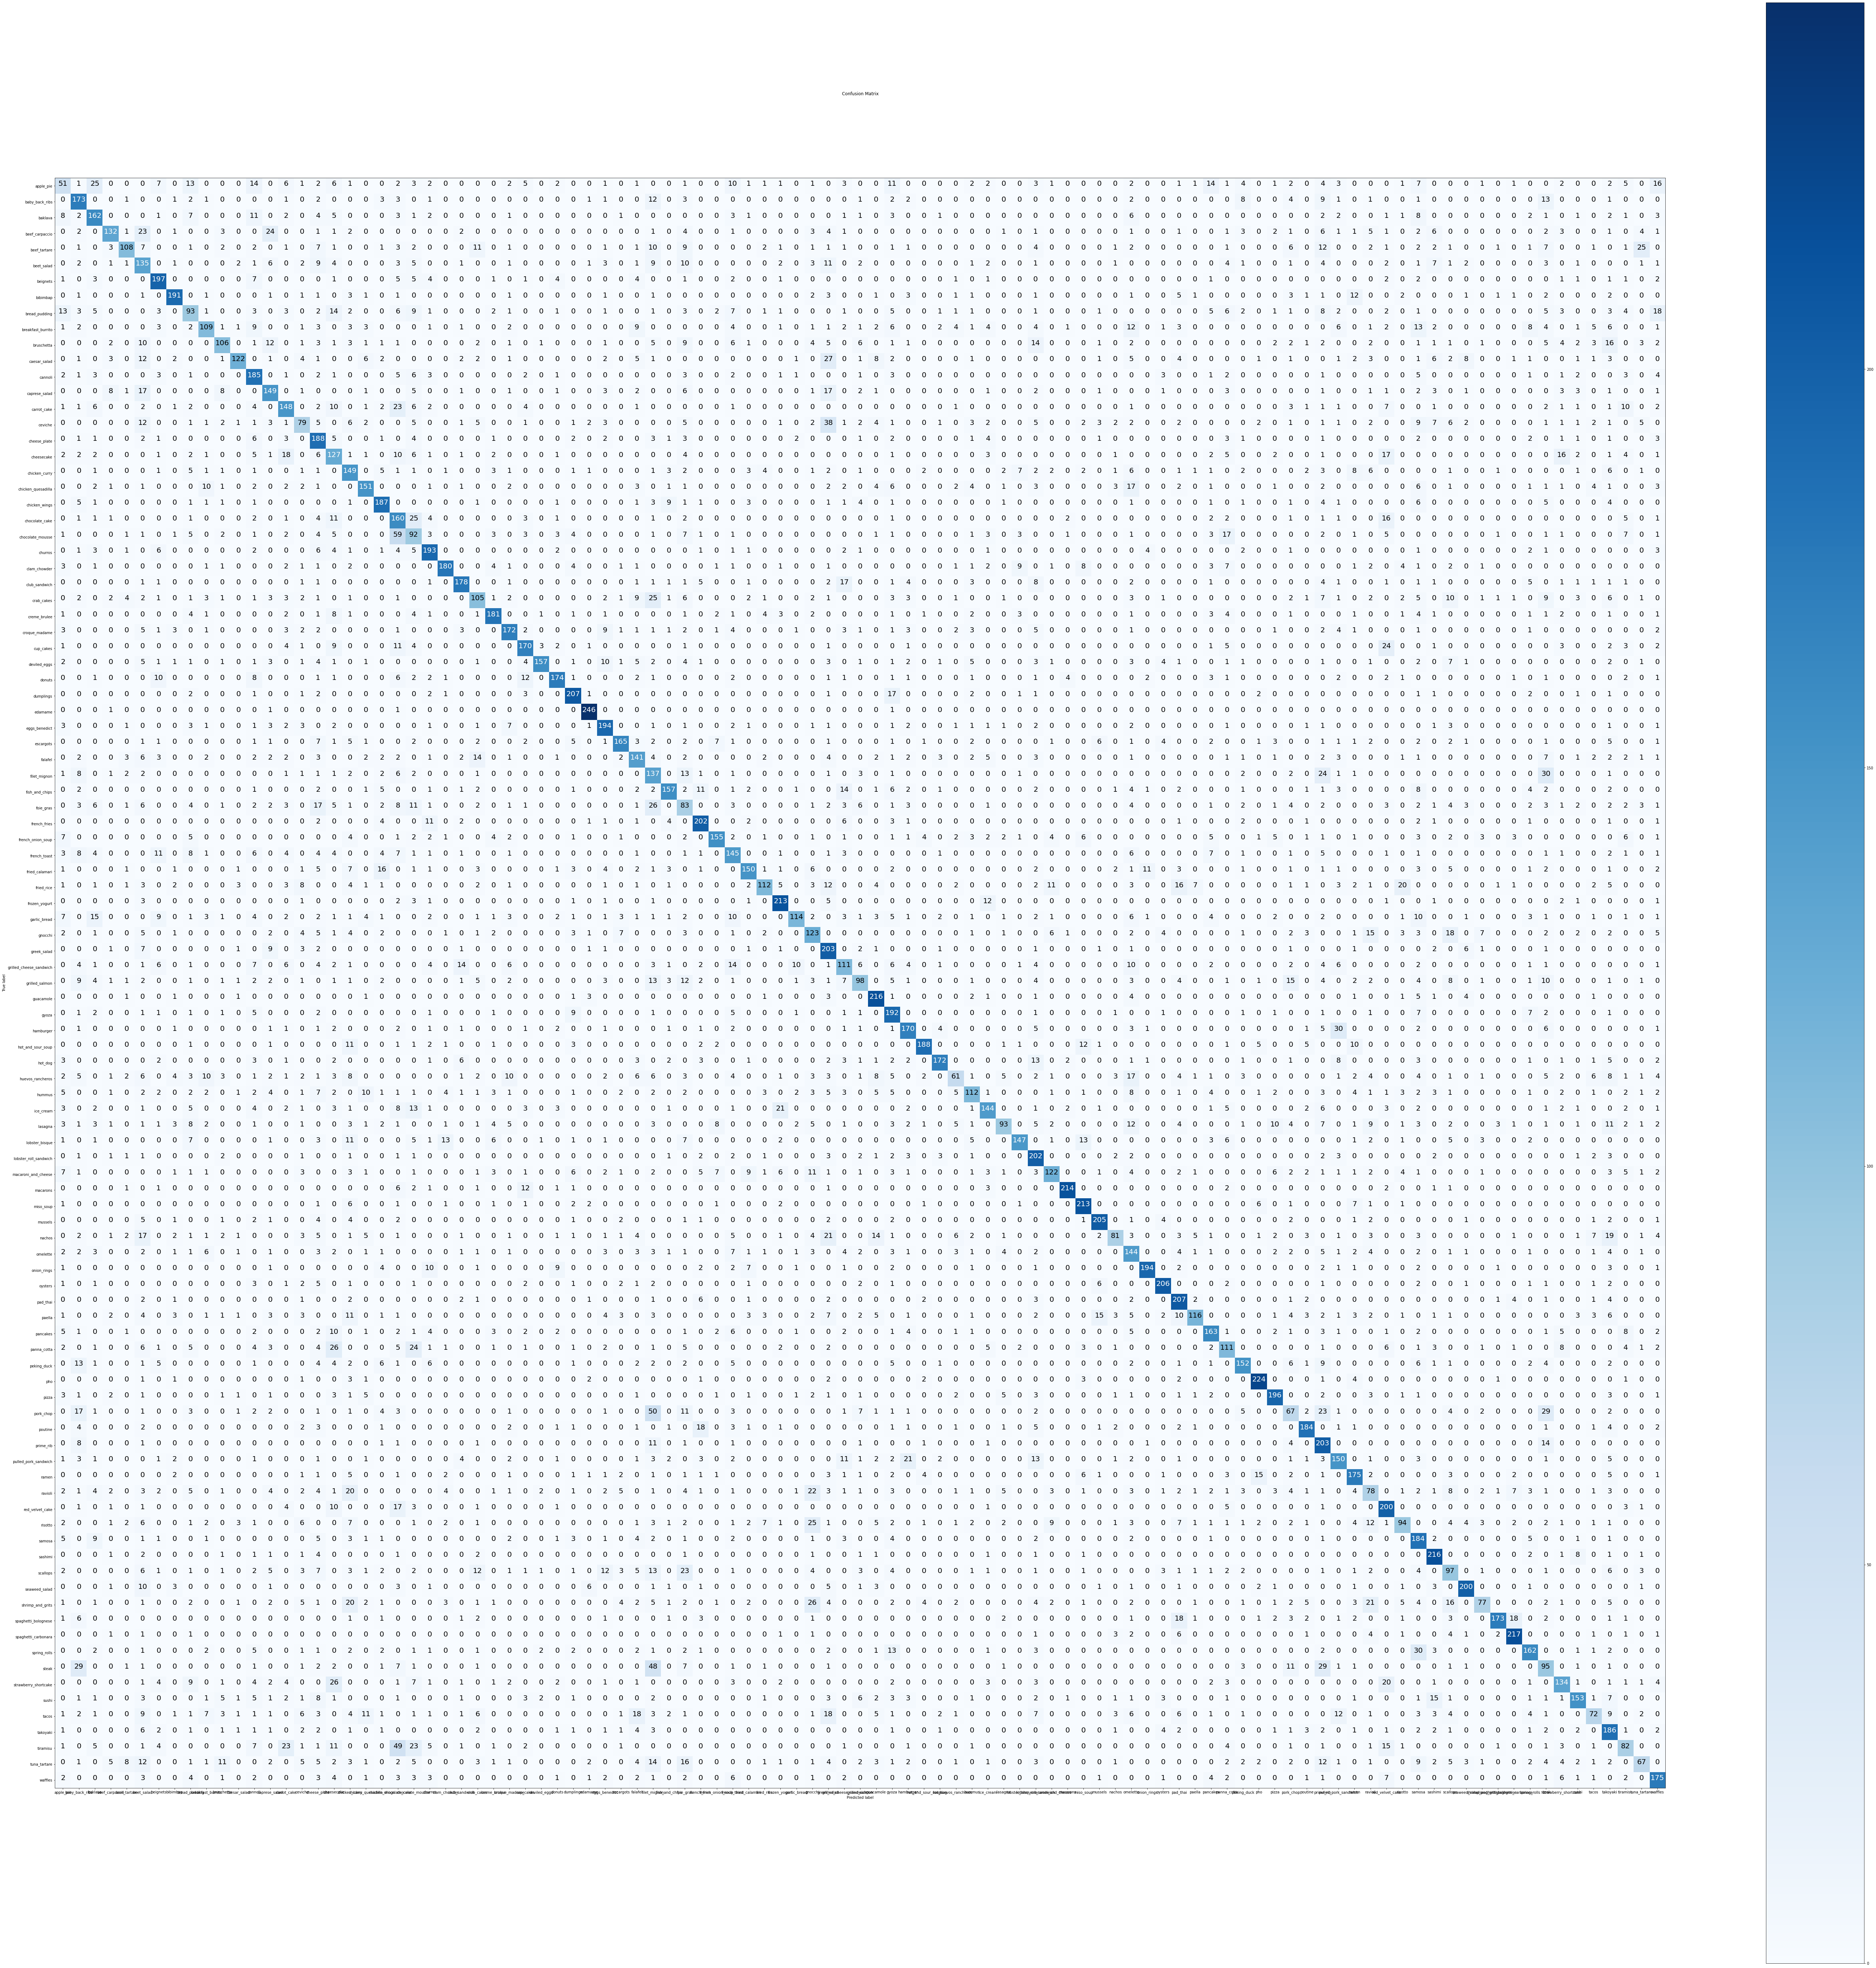

In [ ]:
# Printing a full confusion matrix to better understand the predictions
make_confusion_matrix(y_true=y_labels,
                      y_pred=preds_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
# Evaluating using sklearn classification_report method
classification_report = sklearn.metrics.classification_report(y_labels,
                                            preds_classes,
                                            output_dict=True)

In [ ]:
# Extracting only the f1 scores from the report
f1_scores = {}

for k, v in classification_report.items():
  if k == "accuracy":
    break
  else:
    f1_scores[class_names[int(k)]] = v["f1-score"]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Using pandas to visualize the data
f1_report_sorted = pd.DataFrame({"f1": f1_scores.keys(), "values": f1_scores.values()}).sort_values(by="values", ascending=False)

In [ ]:
f1_report_sorted[:10]

,f1,values
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


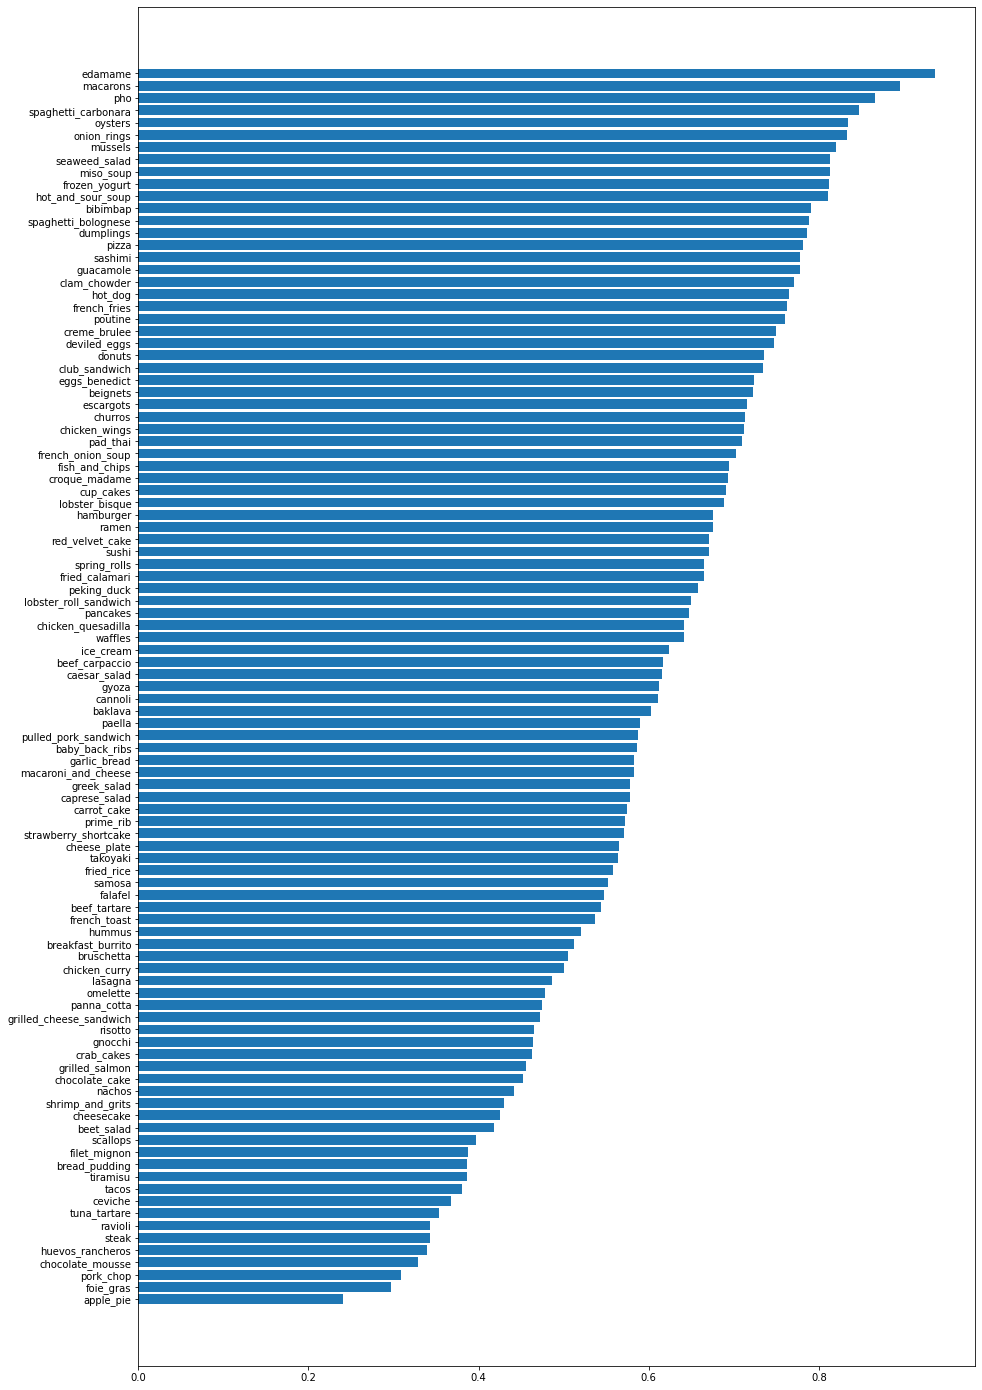

In [ ]:
# Visualizing the f1 scores of every class predictions
fig, ax = plt.subplots(figsize=(15,25))

ax.barh(range(len(f1_scores)), f1_report_sorted["values"])
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_report_sorted["f1"])
ax.invert_yaxis()

## Using only Feeature Extraction model

bulding feature-extraction model and tranning it for 10 epochs on 10 percent of the data

In [ ]:
# Building augmentation layer
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential
augmentation_layer = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
# Building, Compiling and trainig the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainning = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = augmentation_layer(inputs, training=True)

x = base_model(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(101, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_3 = model_3.fit(train_data_10_percent,
                        epochs=10)

Epoch 1/10
237/237 [==============================] - 222s 888ms/step - loss: 3.1639 - accuracy: 0.2719
Epoch 2/10
237/237 [==============================] - 173s 728ms/step - loss: 1.9799 - accuracy: 0.4980
Epoch 3/10
237/237 [==============================] - 159s 670ms/step - loss: 1.5437 - accuracy: 0.5909
Epoch 4/10
237/237 [==============================] - 147s 620ms/step - loss: 1.2711 - accuracy: 0.6539
Epoch 5/10
237/237 [==============================] - 139s 586ms/step - loss: 1.0407 - accuracy: 0.7083
Epoch 6/10
237/237 [==============================] - 140s 587ms/step - loss: 0.8650 - accuracy: 0.7523
Epoch 7/10
237/237 [==============================] - 138s 580ms/step - loss: 0.7046 - accuracy: 0.7999
Epoch 8/10
237/237 [==============================] - 114s 481ms/step - loss: 0.6264 - accuracy: 0.8123
Epoch 9/10
237/237 [==============================] - 115s 482ms/step - loss: 0.5441 - accuracy: 0.8362
Epoch 10/10
237/237 [==============================] - 109s 457m

In [ ]:
# Evaluation
results_10_epochs_model = model_3.evaluate(test_data)

790/790 [==============================] - 120s 150ms/step - loss: 2.0802 - accuracy: 0.5510


In [ ]:
# Compering the model results to the loaded model results
results_10_epochs_model

[2.0801806449890137, 0.5509703159332275]

In [ ]:
loaded_model_results

[1.8027206659317017, 0.6077623963356018]

### Using Mixed Percision

In [ ]:
from tensorflow.keras import mixed_precision

In [ ]:
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

In [ ]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [ ]:
# Building, Compiling and training the model with mixed percision turned on

inputs = tf.keras.Input(shape=(224,224,3))

x = augmentation_layer(inputs, training=True)

x = base_model(x)

Glob_Pool_Layer = tf.keras.layers.GlobalAveragePooling2D()

x = Glob_Pool_Layer(x)

print("global pooling dtype:", x.dtype.name)

Dense_Layer = tf.keras.layers.Dense(101)

x = Dense_Layer(x)

print("dense dtype:", x.dtype.name)

activation = tf.keras.layers.Activation('softmax', dtype='float32')

outputs = activation(x)

print("softmax layer dtype:", outputs.dtype.name)

model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_4 = model_4.fit(train_data_10_percent,
                        epochs=5)



237/237 [==============================] - 109s 459ms/step - loss: 0.5526 - accuracy: 0.8392
Epoch 4/5
237/237 [==============================] - 103s 432ms/step - loss: 0.5038 - accuracy: 0.8490
Epoch 5/5
237/237 [==============================] - 103s 434ms/step - loss: 0.4085 - accuracy: 0.8778


In [ ]:
# Evaluating
mixed_percision_eval_data = model_4.evaluate(test_data)

790/790 [==============================] - 105s 130ms/step - loss: 2.2637 - accuracy: 0.5493


In [ ]:
mixed_percision_eval_data

[2.263700008392334, 0.5492673516273499]